## Web scrapping using python

#### References
1. [Practical Introduction to Web Scraping in Python](https://realpython.com/python-web-scraping-practical-introduction/)
2. [Web Scraping using Python](https://www.datacamp.com/community/tutorials/web-scraping-using-python)

In [1]:
# $ python3 -m venv venv
# $ . ./venv/bin/activate

In [52]:
#Better
#!pip install requests BeautifulSoup4 fire
#!pip install lxml
#!pip install bs4
#!pip install html5lib
#!pip install seaborn
!pip install wordcloud

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [189]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import pandas as pd
import os, sys
import tweepy
from tweepy import OAuthHandler
from tweepy import API
from tweepy import Cursor
from datetime import datetime, date, time, timedelta
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re
import fire
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

In [190]:
#%%writefile ../pyscrap_url.py

def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content  #.encode(BeautifulSoup.original_encoding)
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)
    
def get_tag_elements(url, tag='',search={}, fname=None):
    """
    Downloads a page specified by the url parameter
    and returns a list of strings, one per tag element
    """
    
    if isinstance(url,str):
        response = simple_get(url)
    else:
        #if already it is a loaded html page
        response = url

    if response is not None:
        html = BeautifulSoup(response, 'html.parser')
        
        res = []
        if tag:    
            for li in html.select(tag):
                for name in li.text.split('\n'):
                    if len(name) > 0:
                        res.append(name.strip())
                       
                
        if search:
            soup = html            
            
            
            r = ''
            if 'find' in search.keys():
                print('findaing',search['find'])
                soup = soup.find(**search['find'])
                r = soup

                
            if 'find_all' in search.keys():
                print('findaing all of',search['find_all'])
                r = soup.find_all(**search['find_all'])
   
            if r:
                for x in list(r):
                    if len(x) > 0:
                        res.extend(x)
            
        return res

    # Raise an exception if we failed to get any data from the url
    raise Exception('Error retrieving contents at {}'.format(url))    
    
    
if get_ipython().__class__.__name__ == '__main__':
    fire(get_tag_elements)

# Scraping Data

## Scraping African Leaders Usernames

In [160]:
url= 'https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/#east-africa'
response = simple_get(url)
res1 = get_tag_elements(response, search={'find_all':{'class_':'twitter-tweet'}})
str_cells2=str(res1)
cleantext=BeautifulSoup(str_cells2).get_text()
data=[]
for item in cleantext.split("20,"):
    clean=re.compile(r'@(\w*)')
    clean2=re.search(clean,item)
    if clean2 is not None:
        data.append({'value': clean2.group(0) })
    
    
df=pd.DataFrame(data)
df.columns = ["African leaders"]
df.to_csv('leaders.csv')

findaing all of {'class_': 'twitter-tweet'}


In [161]:
#removing @
leaders = pd.read_csv('leaders.csv')
leaders =leaders['African leaders'].replace('@','', regex=True)
leaders

0     EswatiniGovern1
1          MalawiGovt
2         hagegeingob
3           FinanceSC
4        PresidencyZA
5         Dora_Siliya
6         edmnangagwa
7          MinSantedj
8             hawelti
9     StateHouseKenya
10                WHO
11         M_Farmaajo
12      SouthSudanGov
13      SudanPMHamdok
14     TZSpokesperson
15     KagutaMuseveni
16       angola_Mirex
17      willynyamitwe
18          Cherif_MZ
19     Presidence_RDC
20       PresidentABO
21          gouvbenin
22       rochkaborepf
23      PresidenciaCV
24     AOuattara_PRCI
25     Presidency_GMB
26         NAkufoAddo
27       President_GN
28           USEmbalo
29     PresidenceMali
30    CheikhGhazouani
31        IssoufouMhm
32            MBuhari
33         PaulKagame
34       PresidentBio
35          MSPS_Togo
Name: African leaders, dtype: object

## Scraping Influencer usernames

In [162]:
res = get_tag_elements('https://africafreak.com/100-most-influential-twitter-users-in-africa','h2')
df = pd.DataFrame(res)
df.head(10)

,0
0,100. Jeffrey Gettleman (@gettleman)
1,99. Africa24 Media (@a24media)
2,98. Scapegoat (@andiMakinana)
3,97. Africa Check (@AfricaCheck)
4,96. James Copnall (@JamesCopnall)
5,95. Online Africa (@oafrica)
6,94. Patrick Ngowi (@PatrickNgowi)
7,93. DOS African Affairs (@StateAfrica)
8,92. MoadowAJE (@Moadow)
9,91. Brendan Boyle (@BrendanSAfrica)


In [16]:
targets = pd.DataFrame()

for target in df5:
    try:
        
        print("Getting data for " + target)
        tweets = api.user_timeline(screen_name=target,count=5,include_rts=False)
        user_details = api.get_user(target)
        tweet_list = [tweet for tweet in tweets]
        counter = 0
        favcounter= 0
        #initializing dataframe to store the data
        #targets = pd.DataFrame(columns=['username','popularity score','reach score','relevance score'])
        
        #for tweet in tweet_list:
            #retweetcount = tweet.retweet_count
            #favorite = tweet.favorite_count
            #counter += retweetcount
            #favcounter += favorite
            #mentions = tweet.user_mentions
            #print('mentions   ',mentions)
            #print(tweet.text)
            #print('number of retweets ' , retweetcount)
            #print('number of likes ' , favorite)
            #popularity_score = counter + favcounter   
            
            
            
        #followers_count = user_details.followers_count
        #friends_count = user_details.friends_count
        print('number of followers ',followers_count )
        print('number of people',target,'follows', friends_count)
        #print('popularity score',popularity_score)
        #reachscore = followers_count + friends_count
        #print('reach score ', reachscore)
        data = pd.DataFrame(data=[target], columns=['username'])
        #data['popularity score'] = np.array([popularity_score])
        #data['reach score'] = np.array([reachscore])
        data['number of followers'] = np.array([followers_count])
        data['number of friends'] = np.array([friends_count])
        
        targets=pd.concat([targets,data],ignore_index = True)
        
        #targets.append({'username':target, 'popularity score': popularity_score,'reach score':reachscore,'relevance score' : '0'},ignore_index = True)
        
    except tweepy.TweepError :
        pass


targets

IndentationError: unexpected indent (<ipython-input-16-ace2dde0cbdc>, line 25)

In [163]:
# cleaning the data
df1 = df[0].str.split('.',expand = True)
df1.head(10)
#header = [['position','name','username']]
#df2=pd.DataFrame(header)
#frames= [df2, df1]
#df3=pd.concat(frames)
#print(df3.head(10))
#df4 = df3[1].str.split('(',expand = True)
#df4.head(10)
df2 = df1[1].str.split('(',expand = True)
df2.head(10)
df3 = df2[1].str.split(')',expand = True)
df3.tail(20)
df4 = df3.dropna(axis=0, how='any')
df5 = df4[0].replace('@','', regex=True)
influencers=df5
influencers.to_csv('influencers.csv')

# Extracting Tweets

In [5]:
#
consumer_key = 'OwaWIDBtZ6QOIFjcTH5i6tKPZ'
consumer_secret = 'zsSqmcWmysfz42VgTlw401KmLNAYI2tvEUTW2ISX5vHnyoRHx8'
access_token = '275506568-ASxyT5sfrVXM17QIlGL5j2Ws2Qv2PHIyH4Fc8U0M'
access_token_secret = 'TE8xLOJQFD8uZrqS8xq3akXKy1aOBkVC6uOQ6A52Cvnc4'
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = API(auth)

**getting account details for african leaders**

In [185]:
targets=pd.DataFrame()
for target in leaders:
    try:
        print("Getting data for " + target)
        #tweets = api.user_timeline(screen_name=target,count=5,include_rts=False)
        user_details = api.get_user(target)
        followers_count = user_details.followers_count
        friends_count = user_details.friends_count
        print('number of followers ',followers_count )
        print('number of people',target,'follows', friends_count)
        status_count = user_details.statuses_count
        data = pd.DataFrame(data=[target], columns=['username'])
        data['number of followers'] = np.array([followers_count])
        data['number of friends'] = np.array([friends_count])
        data['status count'] = np.array([status_count])
        targets = pd.concat([targets,data],ignore_index = True)
        #targets.append({'username':target, 'popularity score': popularity_score,'reach score':reachscore,'relevance score' : '0'},ignore_index = True)

    except tweepy.TweepError :
        pass


Getting data for EswatiniGovern1
number of followers  11336
number of people EswatiniGovern1 follows 82
Getting data for MalawiGovt
number of followers  39387
number of people MalawiGovt follows 26
Getting data for hagegeingob
number of followers  192641
number of people hagegeingob follows 55
Getting data for FinanceSC
number of followers  127
number of people FinanceSC follows 224
Getting data for PresidencyZA
number of followers  1600545
number of people PresidencyZA follows 14
Getting data for Dora_Siliya


KeyboardInterrupt: 

## Getting Tweets For African Leaders

In [186]:
Tweets = pd.DataFrame()
for target in leaders:
    try:
        print("Getting data for " + target)
        tweets = api.user_timeline(screen_name=target,count=1000,include_rts=False)
        user_details = api.get_user(target)
        tweet_list = [tweet for tweet in tweets]
        for tweet in tweet_list:
            text = tweet.text
            retweets=tweet.retweet_count
            entities = tweet.entities
            favorite = tweet.favorite_count
            text_df = pd.DataFrame(data=[target],columns = ['user'])
            text_df['tweet'] = np.array([text])
            text_df['number of retweets'] = np.array([retweets])
            text_df['number of likes'] = np.array([favorite])
            text_df['entities'] = np.array([entities])
            hashtags = tweet.entities['hashtags']
            
            if hashtags:
                
                ht = [ht['text'] for ht in hashtags]
                ht=' '.join( ht )
                text_df['hashtags'] = ht
                
                
                
            user_mentions = tweet.entities['user_mentions']
            if user_mentions:
                mentions = [user['screen_name'] for user in user_mentions]
                mentions=' '.join(mentions)
                text_df['mentions'] = mentions
            Tweets=pd.concat([Tweets,text_df],ignore_index=True)
            Tweets.to_csv('leadertw.csv')
    except tweepy.TweepError:
        pass
Tweets.tail()

Getting data for EswatiniGovern1


C:\Users\Ken\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Getting data for MalawiGovt
Getting data for hagegeingob
Getting data for FinanceSC
Getting data for PresidencyZA
Getting data for Dora_Siliya
Getting data for edmnangagwa
Getting data for MinSantedj
Getting data for hawelti


KeyboardInterrupt: 

## Getting Influencer Tweets

In [187]:
Tweets = pd.DataFrame()
for target in influencers:
    try:
        print("Getting data for " + target)
        tweets = api.user_timeline(screen_name=target,count=1000,include_rts=False)
        user_details = api.get_user(target)
        tweet_list = [tweet for tweet in tweets]
        for tweet in tweet_list:
            text = tweet.text
            retweets=tweet.retweet_count
            entities = tweet.entities
            favorite = tweet.favorite_count
            text_df = pd.DataFrame(data=[target],columns = ['user'])
            text_df['tweet'] = np.array([text])
            text_df['number of retweets'] = np.array([retweets])
            text_df['number of likes'] = np.array([favorite])
            text_df['entities'] = np.array([entities])
            hashtags = tweet.entities['hashtags']
            
            if hashtags:
                
                ht = [ht['text'] for ht in hashtags]
                ht=' '.join( ht )
                text_df['hashtags'] = ht
                
                
                
            user_mentions = tweet.entities['user_mentions']
            if user_mentions:
                mentions = [user['screen_name'] for user in user_mentions]
                mentions=' '.join(mentions)
                text_df['mentions'] = mentions
            Tweets=pd.concat([Tweets,text_df],ignore_index=True)
            #Tweets.to_csv('influencertweets.csv')
    except tweepy.TweepError:
        pass
Tweets.tail()

Getting data for gettleman


C:\Users\Ken\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Getting data for a24media


KeyboardInterrupt: 

## Getting common hashtags used by african leaders in their top 5 post retweets

getting data for EswatiniGovern1
getting data for MalawiGovt
getting data for hagegeingob
getting data for FinanceSC
getting data for PresidencyZA
getting data for Dora_Siliya
getting data for edmnangagwa
getting data for MinSantedj
getting data for hawelti
getting data for StateHouseKenya
getting data for WHO
getting data for M_Farmaajo
getting data for SouthSudanGov
getting data for SudanPMHamdok
getting data for TZSpokesperson
getting data for KagutaMuseveni
getting data for angola_Mirex
getting data for willynyamitwe
getting data for Cherif_MZ
getting data for Presidence_RDC
getting data for PresidentABO
getting data for gouvbenin
getting data for rochkaborepf
getting data for PresidenciaCV
getting data for AOuattara_PRCI
getting data for Presidency_GMB
getting data for NAkufoAddo
getting data for President_GN
getting data for USEmbalo
getting data for PresidenceMali
getting data for CheikhGhazouani
getting data for IssoufouMhm
getting data for MBuhari
getting data for PaulKagame
g

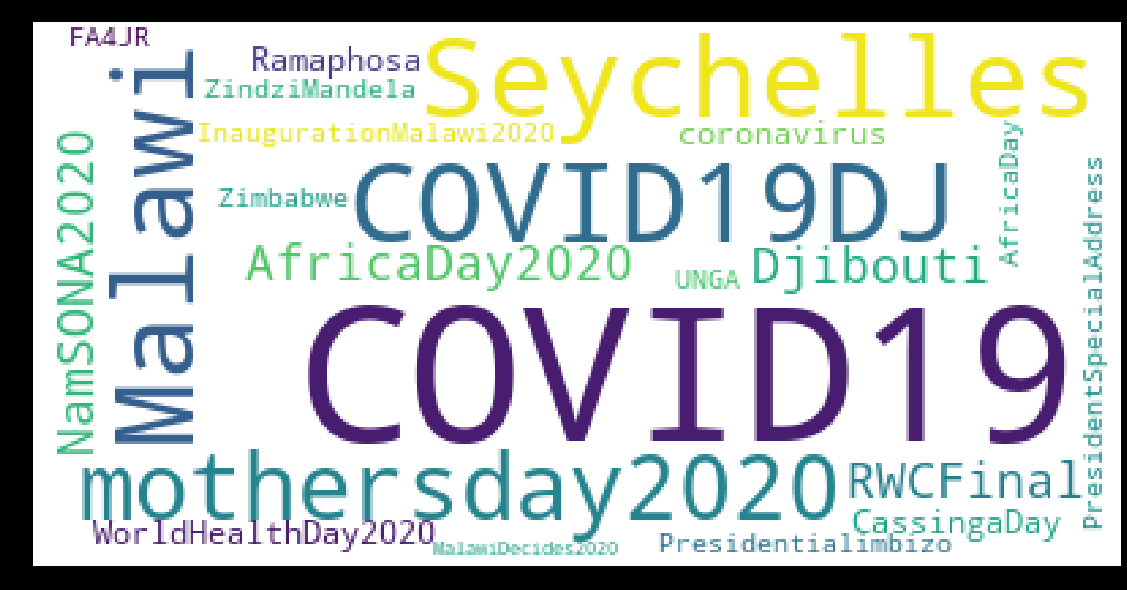

In [234]:
df700 = pd.read_csv('leadertw.csv')
df6=pd.read_csv('influencerusrname.csv')

ranked=pd.DataFrame()
for target in leaders:
    print ('getting data for',target)
    ken=df700.where(df700['user'] == target)
   
    ranking=ken.sort_values(['number of retweets'],ascending = [False])
    ranking=ranking.dropna(subset=['hashtags'])
    ranking=ranking.head(5)
    ranked=pd.concat([ranked, ranking],ignore_index = True)
hashtags = ranked['hashtags']
print(hashtags.value_counts())
def wordcloud(hashtags):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in hashtags]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("most comon hashtags")
wordcloud(hashtags)  


## most common hashtags used by influencers

COVID19                               15
Somalia                                5
Loadshedding                           5
euNITE947                              4
LiveAMP                                4
BlackLivesMatter                       4
MatchInAfrica                          4
SouthAfrica                            3
MandelaDay                             3
FathersDay                             3
GoodMorningAfrica                      3
SARIEGESELS                            3
entrepreneurs                          3
Covid19                                3
NationalAssembly                       3
Congo                                  3
InfoSession                            2
startups                               2
coronavirus                            2
SchoolMealsNow                         2
CNBCAfrica                             2
Fisherman                              2
EasternCape Covid19                    2
Kenyan                                 2
DidYouKnow      

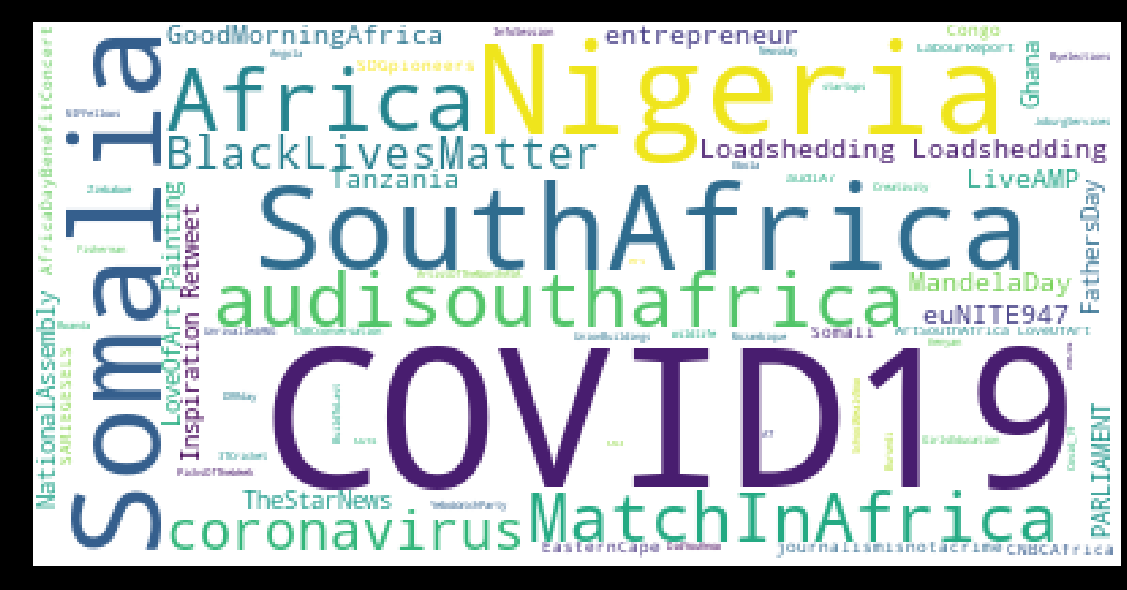

In [236]:
df700 = pd.read_csv('extract.csv')

ranked=pd.DataFrame()
for target in influencers:
    #print ('getting data for',target)
    ken=df700.where(df700['user'] == target)
    ranking=ken.sort_values(['number of retweets'],ascending = [False])
    ranking=ranking.dropna(subset=['hashtags'])
    ranking=ranking.head(5)
    ranked=pd.concat([ranked, ranking],ignore_index = True)
hashtags = ranked['hashtags']
print(hashtags.value_counts())
def wordcloud(hashtags):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in hashtags]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("most comon hashtags")
wordcloud(hashtags)  

# Ranking influencers and african leaders

## follower/following ratio,mention ratio, interaction ratio

In [147]:
data = pd.read_csv('usr.csv')
tweets = pd.read_csv('extract.csv')
for user in leaders.head(2):
    following = data['number of friends']
    followers =data['number of followers']
    rf=followers/following
    data['rf'] = rf
    df300=df200.where(df200['user'] == user)
    df300=df300.dropna(subset=['mentions'])
    status_count=users.where(users['username'] == user)
    status_count=status_count.dropna()
    status_count=status_count['status count'].values[0]
    #print('number of status',status_count)
    #print('posts with mentions',len(ken))
    mentions = len(df300)
    mention_ratio = mentions/status_count
    #print('mention ratio',mention_ratio)
    data['mention ratio'] = mention_ratio
    interaction_ratio = mentions/data['number of followers']
    data['interaction ratio'] = interaction_ratio
    SNP = (rf+interaction_ratio)/2
    
    data['snp'] = SNP
    
data=data.sort_values(['snp'],ascending=False)
data[['username','snp']]

,username,snp
38,africamedia_CPJ,inf
7,StateAfrica,inf
72,SmithInAfrica,inf
78,BBCAndrewH,inf
26,thisisafrica,inf
91,Trevornoah,1.662707e+04
79,euphonik,1.350167e+04
62,IECSouthAfrica,1.004118e+04
82,MTVbaseAfrica,6.495151e+03
89,News24,2.834720e+03


# Common words used in influencers and african leaders tweets

## common words in influencer tweets

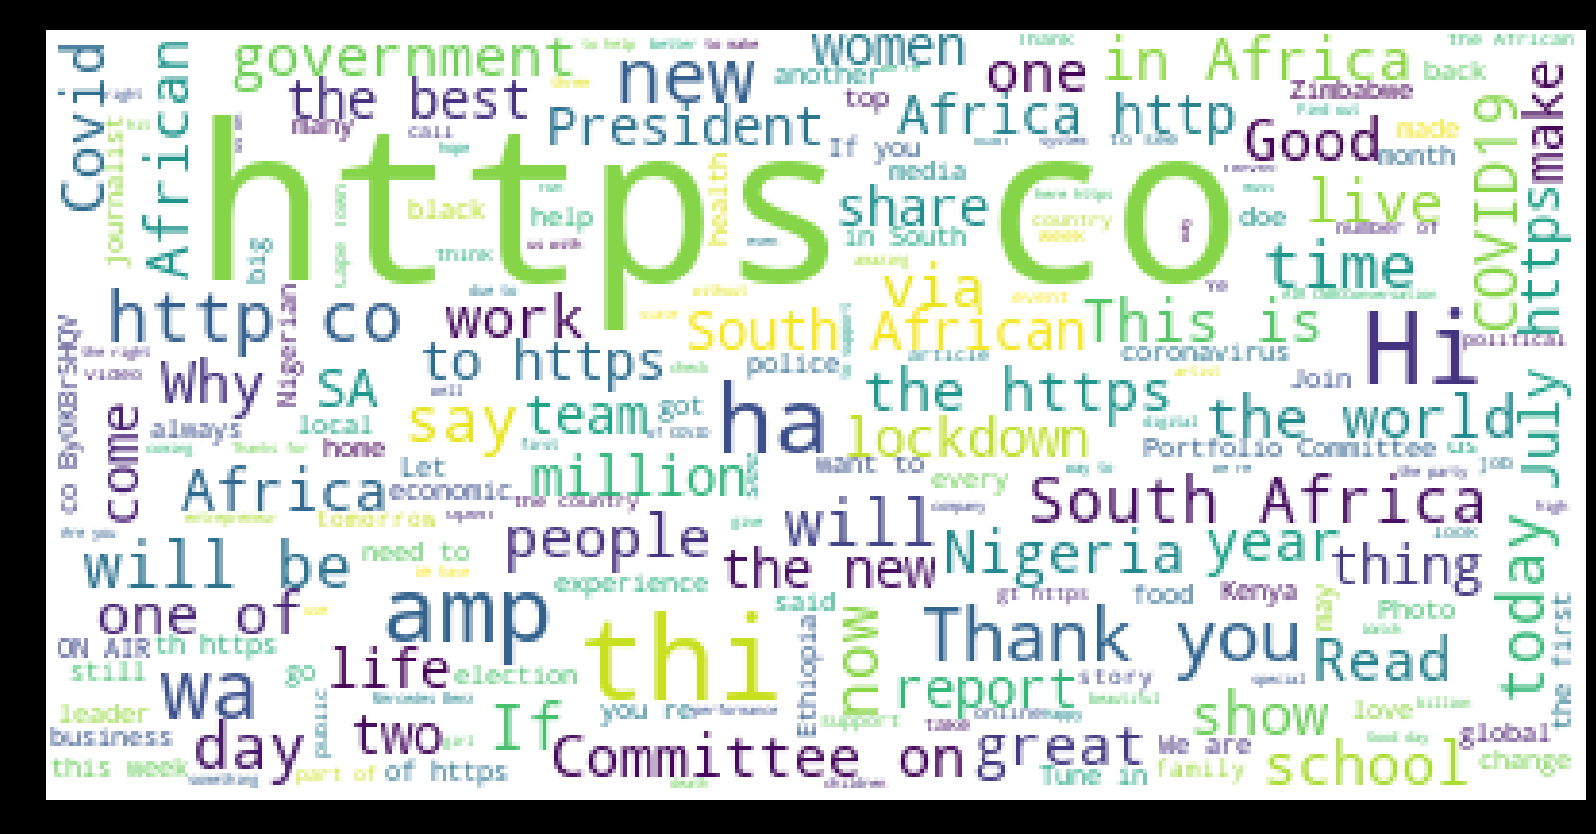

In [87]:
tweets=df700['tweet']

def wordcloud(tweets):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in tweets]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("most comon words used in influencer tweets")
wordcloud(tweets)  

## Common words in african leaders tweets

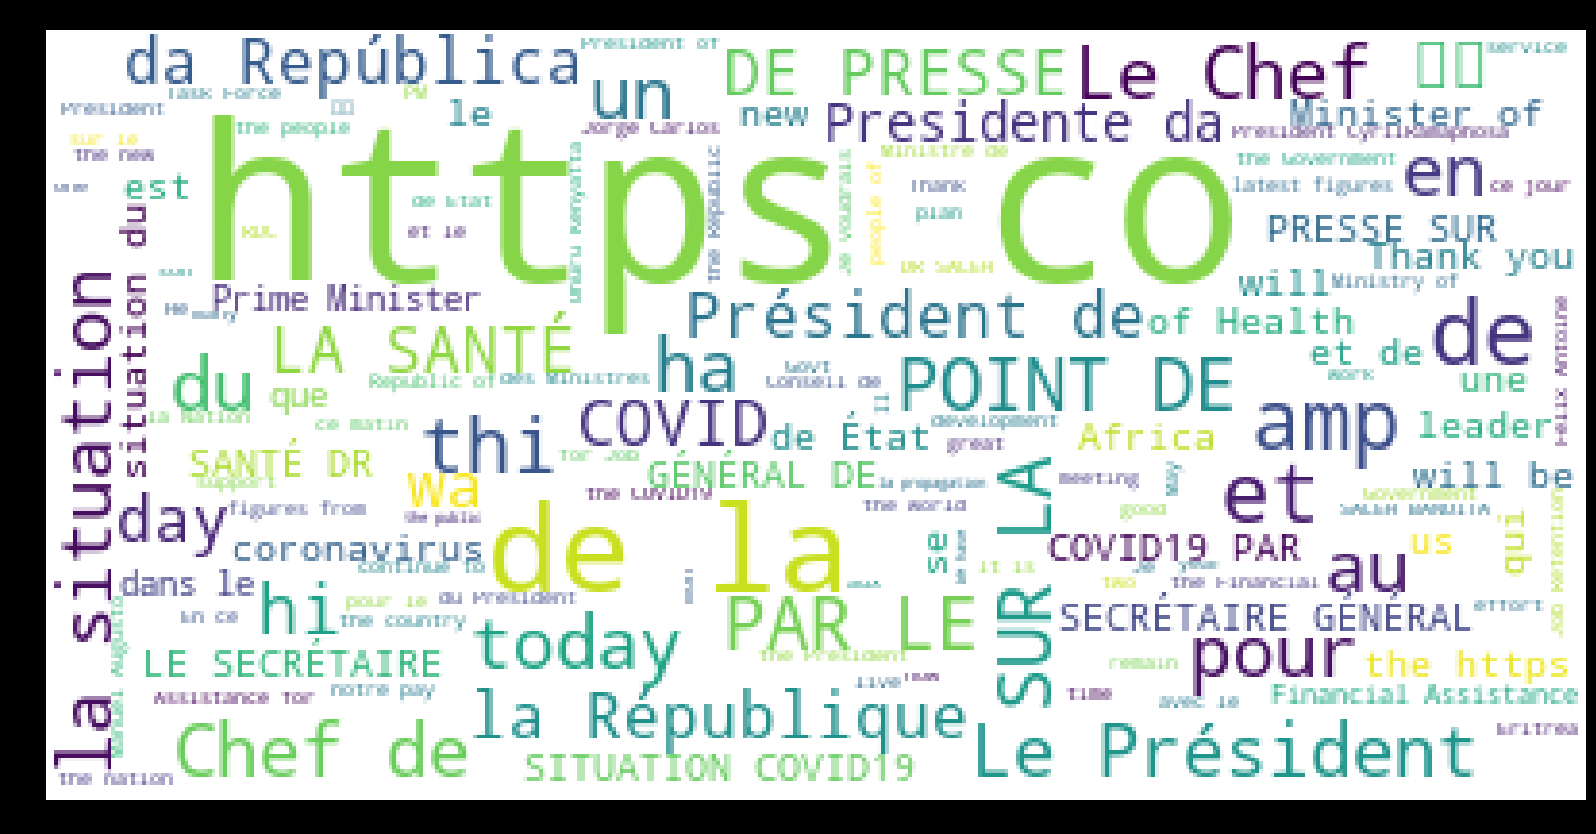

In [88]:
df800 = pd.read_csv('leadertw.csv')
tweets = df800['tweet']
def wordcloud(tweets):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in tweets]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("most comon words used in african leaders tweets")
wordcloud(tweets)  